In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import logging

from IPython.display import display
from matplotlib import pyplot as plt
import datetime as dt
from pathlib import Path
import tempfile
import pandas as pd
from sklearn.model_selection import train_test_split

from gobbli.util import TokenizeMethod
from gobbli.io import make_document_windows, pool_document_windows, WindowPooling, PredictOutput
from gobbli.dataset.imdb import IMDBDataset
from gobbli.model.bert import BERT

import benchmark
benchmark.init_benchmark_env()

In [2]:
ds = IMDBDataset.load()
X_train_valid, X_test = ds.X_train(), ds.X_test()
y_train_valid, y_test = ds.y_train(), ds.y_test()

# Sample to 10% to reduce runtime -- we don't need the full dataset for this
# Just want to see if we get a benefit from windowing
VOCAB_SIZE = 2000
SAMPLE_SIZE = 0.1
X_train_valid, _, y_train_valid, _ = train_test_split(X_train_valid, y_train_valid, train_size=SAMPLE_SIZE)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=SAMPLE_SIZE)

In [3]:
X_train_valid_bert, X_test_bert = benchmark.bert_preprocess(X_train_valid), benchmark.bert_preprocess(X_test)

In [4]:
def analyze_all_results(model_cls, all_results_metrics, window_configs):
    all_metrics = pd.DataFrame([{
        "Window Config": w["name"],
        **r,
    } for w, r in zip(window_configs, all_results_metrics)])
    
    display(all_metrics)
    
    fig = plt.figure(figsize=(10, 10))
    
    acc_ax = fig.add_subplot()
    all_metrics.plot(x="Window Config", y="Accuracy", ax=acc_ax, kind="bar")
    
    plt.xlabel("Document Windowing")
    plt.title(f"Model Performance by Document Windowing - {model_cls.__name__}")
    plt.ylim(0, 1)
    
    plt.show()
    
def evaluate_model(model_cls, X, y, test_dataset, param_grid, window_configs, run_kwargs=None):
    all_results = []
    
    for config in window_configs:

        if config["window_len"] is not None:
            X_test, y_test = test_dataset
            
            with tempfile.TemporaryDirectory() as tmpdir:
                tokenizer_path = Path(tmpdir) / "tokenizer"
                
                X_windowed, _, y_windowed = make_document_windows(
                    X,
                    window_len=config["window_len"],
                    y=y,
                    tokenize_method=TokenizeMethod.SENTENCEPIECE,
                    vocab_size=VOCAB_SIZE,
                    model_path=tokenizer_path
                )
                X_test_windowed, X_test_windowed_indices, y_test_windowed = make_document_windows(
                    X_test,
                    window_len=config["window_len"],
                    y=y_test,
                    tokenize_method=TokenizeMethod.SENTENCEPIECE,
                    vocab_size=VOCAB_SIZE,
                    model_path=tokenizer_path
                )
        else:
            X_windowed, y_windowed = X, y
            X_test_windowed, y_test_windowed = test_dataset
                
        print(f"{dt.datetime.now().strftime('[%Y-%m-%d %H:%M:%S]')} "
              f"Evaluating window config: '{config['name']}' ({len(X_windowed)} obs)")
        results = benchmark.run_benchmark_experiment(f"lowresource_{model_cls.__name__}",
            X_windowed, y_windowed, model_cls, param_grid,
            test_dataset=(X_test_windowed, y_test_windowed), run_kwargs=run_kwargs)

        if config["window_len"] is not None:
            pooled_output = PredictOutput(y_pred_proba=results.y_pred_proba)

            pool_document_windows(
                pooled_output,
                X_test_windowed_indices,
                pooling=config["pooling"],
            )
            
        all_results.append(results.metrics())
        
    analyze_all_results(model_cls, all_results, window_configs)
    return all_results

In [5]:
WINDOW_CONFIGS = [{
    "window_len": None,
    "name": "No windowing",
    "pooling": None,
}, {
    "window_len": 50,
    "name": "50-piece windows, mean pooling",
    "pooling": WindowPooling.MEAN,
}, {
    "window_len": 125,
    "name": "125-piece windows, mean pooling",
    "pooling": WindowPooling.MEAN,
}, {
    "window_len": 250,
    "name": "250-piece windows, mean pooling",
    "pooling": WindowPooling.MEAN,
}, {
    "window_len": 50,
    "name": "50-piece windows, max pooling",
    "pooling": WindowPooling.MAX,
}, {
    "window_len": 125,
    "name": "125-piece windows, max pooling",
    "pooling": WindowPooling.MAX,
}, {
    "window_len": 250,
    "name": "250-piece windows, max pooling",
    "pooling": WindowPooling.MAX,
}, {
    "window_len": 50,
    "name": "50-piece windows, min pooling",
    "pooling": WindowPooling.MIN,
}, {
    "window_len": 125,
    "name": "125-piece windows, min pooling",
    "pooling": WindowPooling.MIN,
}, {
    "window_len": 250,
    "name": "250-piece windows, min pooling",
    "pooling": WindowPooling.MIN,
}]

[2019-08-22 16:06:04] Evaluating window config: 'No windowing' (2500 obs)
[2019-08-22 16:12:05] Evaluating window config: '50-piece windows, mean pooling' (8807 obs)
[2019-08-22 16:24:16] Evaluating window config: '125-piece windows, mean pooling' (4775 obs)
[2019-08-22 16:31:39] Evaluating window config: '250-piece windows, mean pooling' (2500 obs)
[2019-08-22 16:36:33] Evaluating window config: '50-piece windows, max pooling' (8807 obs)
[2019-08-22 16:48:42] Evaluating window config: '125-piece windows, max pooling' (4775 obs)
[2019-08-22 16:56:14] Evaluating window config: '250-piece windows, max pooling' (2500 obs)
[2019-08-22 17:01:05] Evaluating window config: '50-piece windows, min pooling' (8807 obs)
[2019-08-22 17:13:14] Evaluating window config: '125-piece windows, min pooling' (4775 obs)
[2019-08-22 17:20:42] Evaluating window config: '250-piece windows, min pooling' (2500 obs)


,Window Config,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy
0,No windowing,0.829830,0.831240,0.830000,0.830000
1,"50-piece windows, mean pooling",0.721250,0.721314,0.721262,0.721262
2,"125-piece windows, mean pooling",0.762451,0.762669,0.762482,0.762482
3,"250-piece windows, mean pooling",0.839035,0.840510,0.839200,0.839200
4,"50-piece windows, max pooling",0.719515,0.719807,0.719578,0.719578
5,"125-piece windows, max pooling",0.756212,0.756245,0.756215,0.756215
6,"250-piece windows, max pooling",0.835410,0.837069,0.835600,0.835600
7,"50-piece windows, min pooling",0.722238,0.723390,0.722497,0.722497
8,"125-piece windows, min pooling",0.753901,0.754024,0.753917,0.753917
9,"250-piece windows, min pooling",0.831044,0.832349,0.831200,0.831200


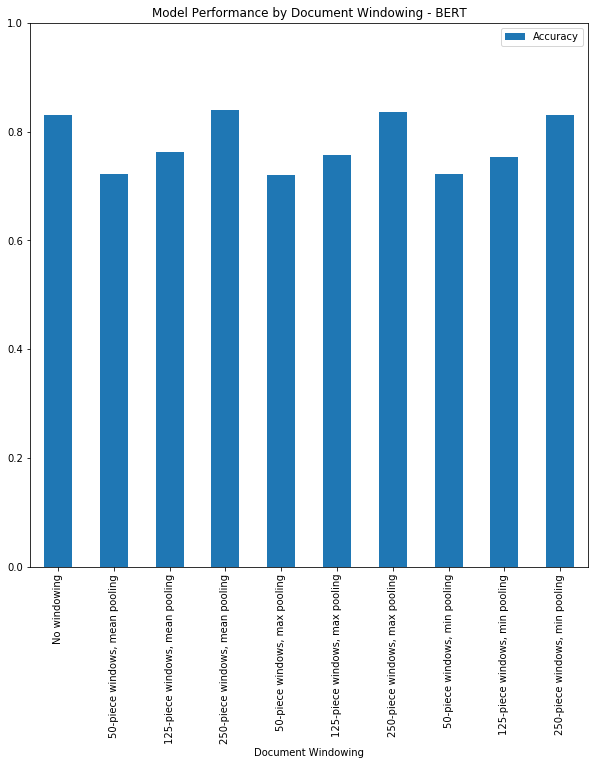

In [6]:
results = evaluate_model(BERT, X_train_valid_bert, y_train_valid, 
                        (X_test_bert, y_test), {}, WINDOW_CONFIGS)